In [1]:
from model_utils.model_process import *
from floortrans.metrics import runningScore
from floortrans.plotting import discrete_cmap
discrete_cmap()

import warnings
warnings.filterwarnings('ignore')

## Data Loader

We employed a **MaskR-CNN model** for room detection. MaskR-CNN is a strong tool for both object detection and instance segmentation. At the end, we would try using it to detect each part of the floorplan, search for some specific room on the floorplan and recover the room segmentation map.

### Data Preprocessing and Augmentation

MaskR-CNN requires the **data loader** containing following inputs:

image: preprocessed to $256\times 256$, the training set includes random horizontal flips.

targets:
- boxes: the bounding boxes of each room instance
- labels: the labels of those rooms
- image_id: the integer identifier of the floorplan
- area: the instance area (based on the mask)
- iscrowd: instances with iscrowd=True will be ignored during evaluation.



The data loader code **CubicasaDataset** is in `model_utils/model_process.py`. We use OpenCV tools to automatically annotate the original floorplan images. 

The specific technique is to first extract each room instance mask out from the segmentation map processed in class `House` of the reference work https://github.com/CubiCasa/CubiCasa5k. They we use tools to find the mask's countour. The countours can further be used to calculate the instance area and find the bounding box vertices.

However, the method above cannot be used to get the accuracy information of walls since different walls are connected in the floorplan and therefore we cannot automatically break them into room pieces and find its target information. As a result, we only processed the other 10 room objects in our training, including "Outdoor", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", and "Undefined".

The ROOM_IDs are:
- Background: 0
- Outdoor:1
- Walls: 2
- Kitchen:3
- Living Room:4
- Bedroom: 5
- Bath: 6
- Entry: 7
- Railing: 8
- Storage: 9
- Garage: 10
- Undefined: 11

Notice that the background id is automatically assigned by the model. And we would add back walls in the postprocessing part.


### Kick out some problematic instances before trainig and evaluation

Our dataloader would automatically print out the instances with empty instances. Below shows some problematic examples we found.


In [2]:
def check_folder(folder_name, img_show = True):
    
        
    svg_path ='./data/cubicasa5k'+folder_name+'model.svg'
    img_path ='./data/cubicasa5k'+folder_name+'F1_scaled.png'
    org_img_path ='./data/cubicasa5k'+folder_name+'F1_original.png'
    height, width, _ = cv2.imread(img_path).shape
    height_org, width_org, _ = cv2.imread(org_img_path).shape

    house = House(svg_path, height, width)
    # Combining them to one numpy tensor
    gt = torch.tensor(house.get_segmentation_tensor().astype(np.float32))

    gt = gt.unsqueeze(0)
    gt = torch.nn.functional.interpolate(gt,size=(height_org, width_org),
                                                            mode='nearest')
    gt = gt.squeeze(0)[0]
    
    org_img = plt.imread(org_img_path)
   
    if img_show:
        
        fig = plt.figure()
        ax = plt.subplot(1, 2, 1)
        ax.imshow(org_img)
        ax.set_title('Original Floorplan', fontsize=10)

        ax = plt.subplot(1,2, 2)
        ax.set_title('Ground Truth segmap', fontsize=10)
        ax.imshow(gt, cmap='rooms', vmin=0, vmax=12-0.1)
        
   
        
        
        fig.suptitle(folder_name)
        plt.show()
        
        
    return gt

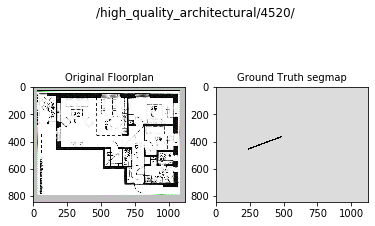

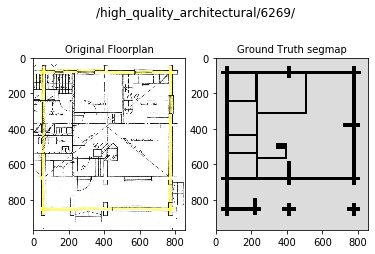

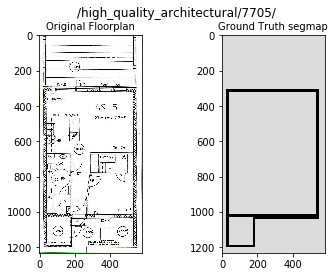

In [3]:
#problematic folders overview
folders = ['/high_quality_architectural/4520/', '/high_quality_architectural/6269/', '/high_quality_architectural/7705/']

for f in folders:
    _ = check_folder(f)
    
    

We can see the ground truth segmentation maps are empty so we simply kick those examples out.

## Training method

The experiment is implemented on AWS Ubuntu 18.04 Deep Learning AMI with NVIDIA K80 GPU. The training script is in `maskrcnn.py`. Below are the details:

- model: torchvision.models.detection.maskrcnn_resnet50_fpn
- pretrained on COCO dataset.
- optimizer: SGD, lr = 0.005, momentum=0.9, weight_decay=0.0005
- lr scheduler: step_size=3,gamma=0.1
- epochs: 5, each takes about 100 mins.
- reference: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

$\mathcal{L} = \mathcal{L}_{classifier} +  \mathcal{L}_{classifier}+ \mathcal{L}_{box reg} + \mathcal{L}_{mask} $ The specific explanation of the losses refers to He et al. https://arxiv.org/pdf/1703.06870.pdf.


In [4]:
#here we use CPU for display
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#use test dataset for display
model, dataset_train, data_loader_train = prepare_model('train')
model, dataset_val, data_loader_val = prepare_model('val')
model, dataset_test, data_loader_test = prepare_model('test')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
    

The losses are decreasing slowly after the second epoch. 

The beginning total loss was 6.6133. The final loss was a sway between 0.6 and 0.7.

## Postprocessing
The **decoder** Decode_Maskrcnn is in `model_utils/model_process.py`. We use a non-maximum suppression on the number of bounding boxes on each floorplan. The suppression condition is that IoU > 1. For soft segmentation mask, we extract the masks with a value threshold >0.1 (the mask pixel values are within \[0,1\]).

### Overview

In [44]:
#load model
model.load_state_dict(torch.load('models/maskrcnn_4_resized.pt',map_location='cpu'))

#Input the dataset name, image_id, model and non-maximum suppression threshold.
dm = Decode_Maskrcnn(dataset_val, 0, model, nms = 1) 

### get ground truth

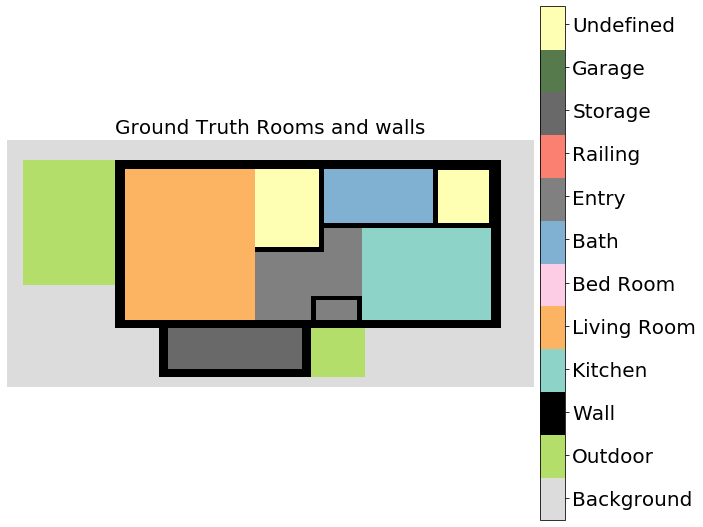

In [45]:
gt = dm.get_groundtruth()

### Get predicted segmentation map

The way to generate segmentation mask is to put the pieces of instances on all masks together and assign the ROOM_ID number on that pixel. Since we didn't have walls on the map, we can recover it by adding back countours with some thickness to the segmentation map.

It would be a better idea to add the edges with some thickness to the map. However, right now we haven't find any efficient way to implement it. This would in some degree affect the evaluation result.

Here we can also see some advantages of MASKR-CNN. Since the rooms are patches on the image, it is consistent with the function of object detection instead of semantic segmentation. The rooms on the segmentation map are patches without too much crosses on other rooms.

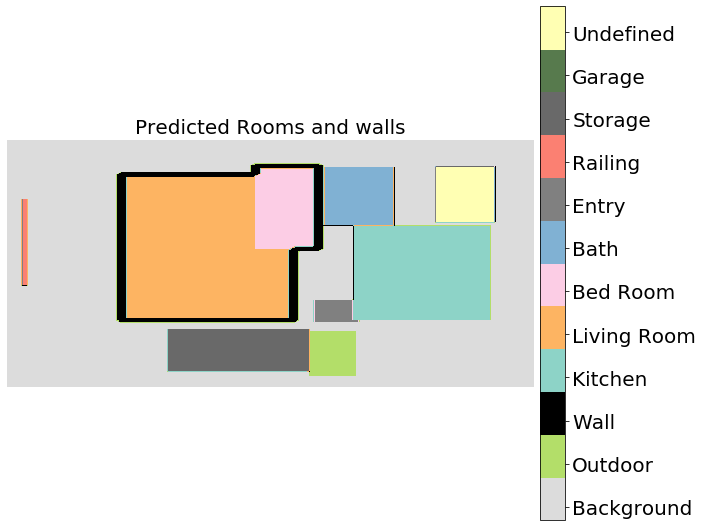

In [46]:
seg_map =  dm.get_segmap(0)

### Room detection

Since we preprocessed the images and bounding boxes with the image size $256 \times 256$, we rescaled the bounding boxes to match the original floorplan.

Our decoder allows to return the proposed regions of some specific rooms.

You can see the model proposed more than one area of bath while in fact there's only one batch on the floorplan. This is the propoerty of object detection model. Maximum suppression thus is very critical to prevent the model from overfitting.

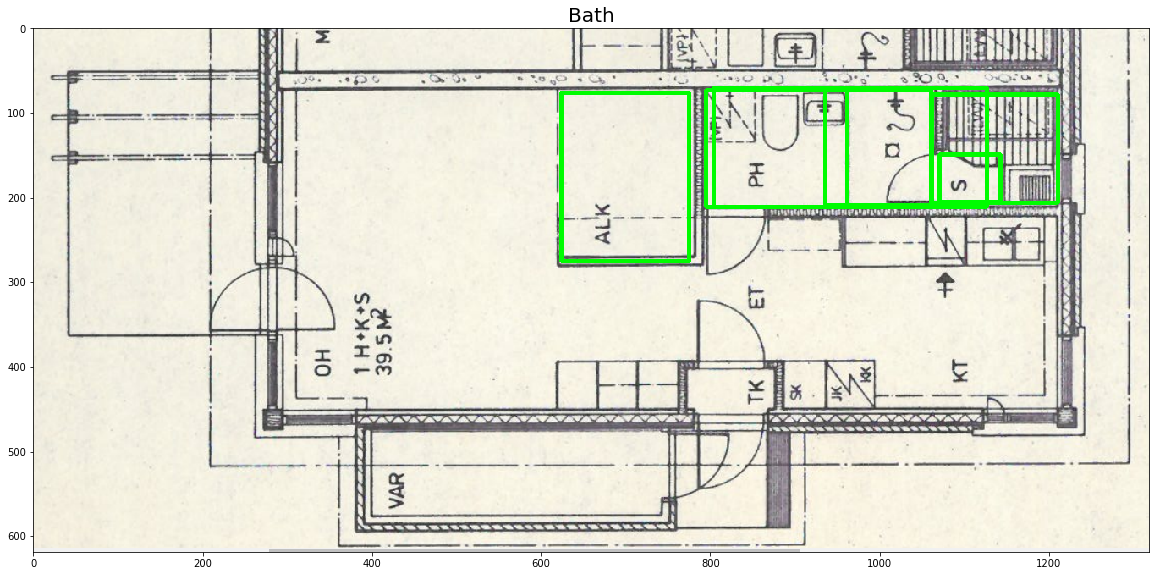

In [47]:
#Enter any room name to search for the room on the floorplan
bed_room =  dm.room_detect(ROOM_LABELS['Bath'])

In [48]:
# report None when no such object detected.
bed_room =  dm.room_detect(ROOM_LABELS['Garage'])

No such object


### Final display

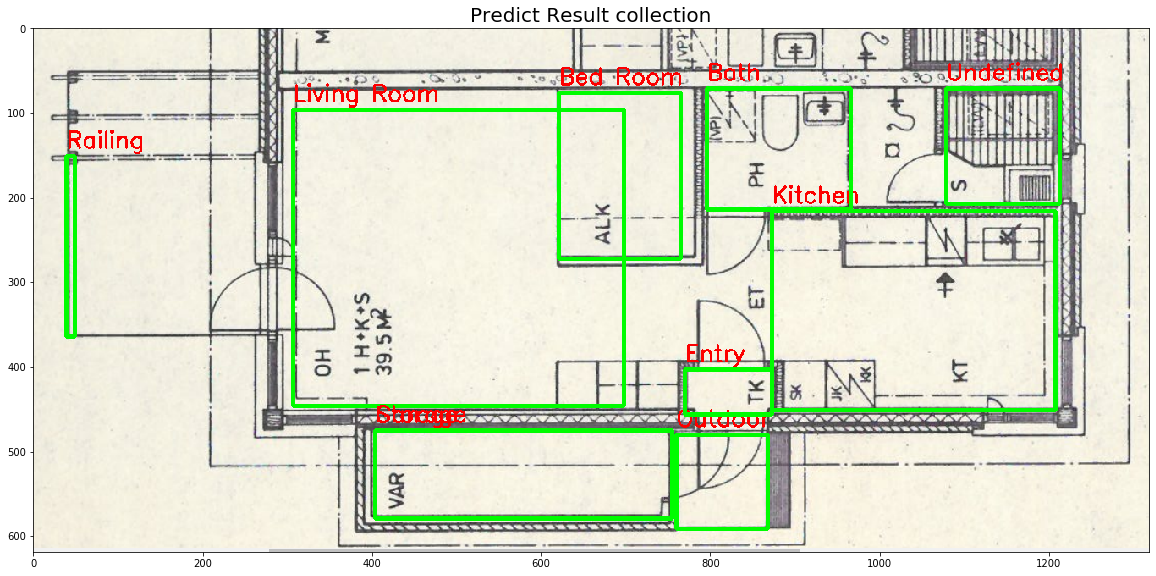

In [49]:
rc = dm.collect_result()

## Result

To evaluate our result, we used the evaluation method used by Kalervo et al. The metrics and terms were explained in https://arxiv.org/abs/1904.01920v1, they are the different types of IoU metrics regarding our postprocessed segmentation maps.

The testing code is in `test_script.py`, mainly referred to the code of Kalervo et al.

The evaluated metrics:
- Overall Acc
- Mean Acc
- Mean IoU

**Validation Evaluation**

| Epochs | Overall Acc | Mean Acc | Mean IoU | 
|--------|-------------|----------|----------|
| 0      | 0\.6062     | 0\.4059  | 0\.2912  |   
| 1      | 0\.6178     | 0\.4306  | 0\.3067  |  
| 2      | 0\.6274     | 0\.4492  | 0\.3199  |  
| 3      | 0\.6340     | 0\.4633  | 0\.3291  |  
| 4      | 0\.6386     | 0\.4737  | 0\.3358  |   



**Test Evaluation**

| Epochs | Overall Acc | Mean Acc | Mean IoU | 
|--------|-------------|----------|----------|
| 0      | 0\.6151     | 0\.4231  | 0\.3027  |   
| 1      | 0\.6253     | 0\.4427  | 0\.3163  |  
| 2      | 0\.6322     | 0\.4572  | 0\.3260  |  
| 3      | 0\.6377     | 0\.4702  | 0\.3341  |  
| 4      | 0\.6413     | 0\.4789  | 0\.3395  |   




**Final class accuracy**

| Class       | Accuracy |
|-------------|----------|
| Background  |  0\.9567 |
| Outdoor     | 0\.4723  |
| Walls       | 0\.2703  |
| Kitchen     | 0\.6434  |
| Living Room | 0\.7392  |
| Bedroom     | 0\.4458  |
| Bath        | 0\.5236  |
| Entry       | 0\.5137  |
| Railing     | 0\.2676  |
| Storage     | 0\.3841  |
| Garage      | 0\.4279  |
| Undefined   | 0\.1015  |







## Discussion

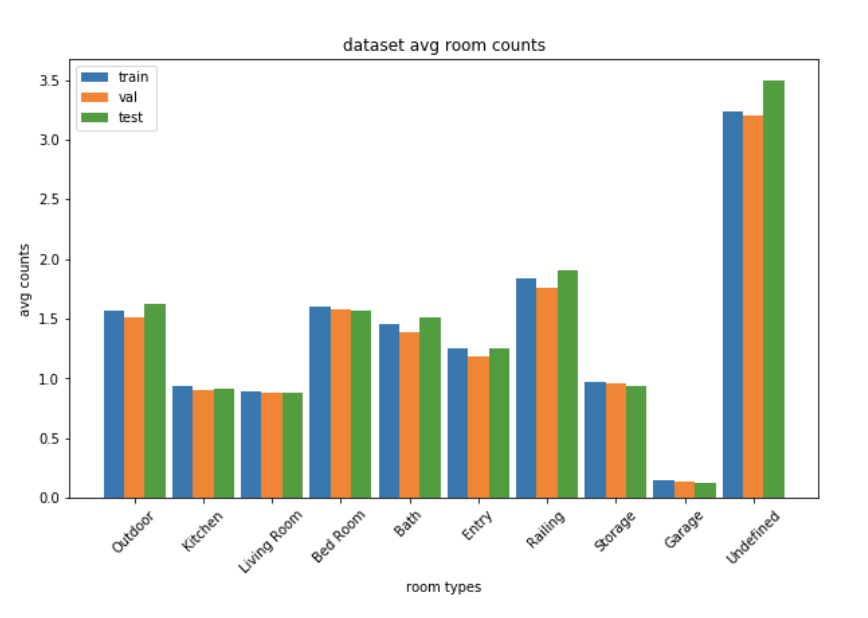

In [53]:
Image.open('deliverable_images/EDA_rooms.png') 

### TODOs

Due to the limit of time, we still have several TODOs in this part.

First, according to the validation and test evaluation, we can see the overall acc/mean acc/ mean IoU is still improving in both validation and test set. That means we haven't fully trained our model. The limit is not only due to the long training time each epoch but also the limit on AWS budget.

Second, according to the EDA result above, that the room counts are not evenly distributed across the dataset. To increase the class accuracy of garage it is necessary to rebalance the dataset.

Finally, the wall recovery is very rough. We may instead combine with semantic segmentation techniques such as UNet and more preprocessing techniques to predict the walls. 

### Result Analysis

As a result, our result is no better than that of Kalervo et al.'s. Besides the reason above, our room detection algorithm haven't include the information of junction points and icons. Some of them are very critical to room identification such as toilet icon in bathroom. 

There are also some interesting findings in the class-wide accuracy. We can see some rooms have higher accuracy than others such as living room, bath, and kitchen. That may attribute to some special icons in these kinds of rooms. The accuracy of walls is very low, but that is not related to the model but our postprocessing method. The accuracy of railing and the undefined are extremely low. Because railing is very thin in the original floorplan. The likelihood of right prediction on pixel is very low. Finally, the undefined rooms are very hard to conclude for our model. Removing it from the input may on the other hand increase the accuracy of other rooms. This is actually a very practical and feasible idea since it is meaningless to recover that room on floorplan without knowing the room type. In our final delivered visualization result, humans could regard all unboxed areas as undefined.

### Future work
Given the discussion above, there are several ways we propose to improve the result.

1. Rebalance the data before training.
2. Increase training epochs until validation reaches the optimum.
3. Include the information of junction points and icons to the inputs.
4. Remove the undefined room information from the training.
5. Combine the results with semantic segmentation methods for some non-patch instance recovery.


### Summary
In summary, we are the first to try the object detection method on Cubicasa dataset to predict both the rooms and segmentation maps. Also, our result generated  visualization of room detection on the floorplan. Although there's no improvement in room segmentation accuracy compared to the work of Kalervo et al., we proposed several TODOs for future works.
